In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output
from time import time
from sympy.printing import latex
from trimesh import viewer as trview
import sklearn

from scipy.optimize import OptimizeResult, minimize, basinhopping, differential_evolution, brute

import tqdm
import otaf

# AI stuff
from efficient_kan import KAN, KANLinear
from lion_pytorch import Lion

ot.Log.Show(ot.Log.NONE)
np.set_printoptions(suppress=True)
ar = np.array


# Notebook for the analysis of a system comprised of N + 2 parts, 2 plates with N = N1 x N2 holes, and N pins. 

### Defintion on global descriptive parameters

In [2]:
NX = 4 ## Number of holes on x axis
NY = 2 ## Number of holes on y axis
Dext = 10 ## Diameter of holes in mm
Dint = 9.8 ## Diameter of pins in mm
EH = 20 ## Distance between the hole axises
hPlate = 10 #Height of the plates in mm
hPin = 20 #Height of the pins in mm

CIRCLE_RESOLUTION = 15 # NUmber of points to model the contour of the outer holes

### Defining and constructing the system data dictionary

The plates have NX * NY + 1 surfaces. The lower left point has coordinate 0,0,0

We only model the surfaces that are touching. 

In [3]:
N_PARTS = NX * NY * 2
LX = (NX + 1) * EH
LY = (NY + 1) * EH

contour_points = ar([[0,0,0],[LX,0,0],[LX,LY,0],[0,LY,0]])

R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

Frame1 = ar([z_,y_,-x_])
Frame2 = ar([-z_,y_,x_])

First we define the base part dictionaries for the upper and lower plate, without holes

In [4]:
system_data = {
    "PARTS" : {
        '0' : {
            "a" : {
                "FRAME": Frame1,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P1a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        },
        '1' : {
            "a" : {
                "FRAME": Frame2,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P0a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        }  
    },
    "LOOPS": {
        "COMPATIBILITY": {
        },
    },
    "GLOBAL_CONSTRAINTS": "3D",
}

Then we iterate over the pin dimensions NX and NY, and create the corresponding holes and pins. At the same time there is 1 loop per pin

In [5]:
alpha_gen = otaf.common.alphabet_generator()
next(alpha_gen) # skipping 'a' as it has already been used above
part_id = 2 # Start part index for pins
for i in range(NX):
    for j in range(NY):
        pcor = ar([(i+1)*EH, (j+1)*EH, 0]) # Point coordinate for hole / pins
        slab = next(alpha_gen) # Surface label, same for each mating pin so its easeir to track
        # Creating pin
        system_data["PARTS"][str(part_id)] = {}
        system_data["PARTS"][str(part_id)][slab] = {
            "FRAME": Frame1, # Frame doesn't really matter, as long as x is aligned on the axis
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dint / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P0{slab}", f"P1{slab}"], 
            "SURFACE_DIRECTION": "centrifugal",
            "CONSTRAINTS_D": ["PERFECT"], # No defects on the pins
            "BLOCK_ROTATIONS_G": 'x', # The pins do not rotate around their axis
            "BLOCK_TRANSLATIONS_G": 'x', # The pins do not slide along their axis
        }
        # Adding hole to part 0
        system_data["PARTS"]["0"][slab] = {
            "FRAME": Frame1,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"], 
            "SURFACE_DIRECTION": "centripetal",
        }
        # Adding hole to part 1
        system_data["PARTS"]["1"][slab] = {
            "FRAME": Frame2,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"],
            "SURFACE_DIRECTION": "centripetal",
        }
        # Construct Compatibility loop
        loop_id = f"L{part_id-1}"
        formater = lambda i,l : f"P{i}{l}{l.upper()}0" 
        system_data["LOOPS"]["COMPATIBILITY"][loop_id] = f"P0aA0 -> {formater(0,slab)} -> {formater(part_id,slab)} -> {formater(1,slab)} -> P1aA0"
        part_id += 1
        

In [6]:
system_data["PARTS"]

{'0': {'a': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'POINTS': {'A0': array([0, 0, 0]),
    'A1': array([100,   0,   0]),
    'A2': array([100,  60,   0]),
    'A3': array([ 0, 60,  0])},
   'TYPE': 'plane',
   'INTERACTIONS': ['P1a'],
   'CONSTRAINTS_D': ['PERFECT'],
   'CONSTRAINTS_G': ['SLIDING']},
  'b': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'ORIGIN': array([20, 20,  0]),
   'TYPE': 'cylinder',
   'RADIUS': 5.0,
   'EXTENT_LOCAL': {'x_max': 10.0, 'x_min': -10.0},
   'INTERACTIONS': ['P2b'],
   'SURFACE_DIRECTION': 'centripetal'},
  'c': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'ORIGIN': array([20, 40,  0]),
   'TYPE': 'cylinder',
   'RADIUS': 5.0,
   'EXTENT_LOCAL': {'x_max': 10.0, 'x_min': -10.0},
   'INTERACTIONS': ['P3c'],
   'SURFACE_DIRECTION': 'centripetal'},
  'd': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),


In [7]:
SDA = otaf.SystemDataAugmented(system_data)
SDA.generate_expanded_loops()

In [8]:
CLH = otaf.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [9]:
ILH = otaf.InterfaceLoopHandling(SDA, CLH, circle_resolution=CIRCLE_RESOLUTION)
interface_constraints = ILH.get_interface_loop_expressions()

	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STA

In [10]:
#SDA.get_notebook_scene_sphere_clouds()

In [11]:
TAMP = otaf.ToleranceAnalysisMatrixPreparer(
    compatibility_expressions, interface_constraints
)

TAMP.embedOptimizationVariable()

print(len(TAMP.deviation_symbols), TAMP.deviation_symbols)

64 [v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_2, w_d_2, beta_d_2, gamma_d_2, v_d_5, w_d_5, beta_d_5, gamma_d_5, v_d_7, w_d_7, beta_d_7, gamma_d_7, v_d_8, w_d_8, beta_d_8, gamma_d_8, v_d_10, w_d_10, beta_d_10, gamma_d_10, v_d_11, w_d_11, beta_d_11, gamma_d_11, v_d_13, w_d_13, beta_d_13, gamma_d_13, v_d_14, w_d_14, beta_d_14, gamma_d_14, v_d_16, w_d_16, beta_d_16, gamma_d_16, v_d_17, w_d_17, beta_d_17, gamma_d_17, v_d_19, w_d_19, beta_d_19, gamma_d_19, v_d_20, w_d_20, beta_d_20, gamma_d_20, v_d_22, w_d_22, beta_d_22, gamma_d_22, v_d_23, w_d_23, beta_d_23, gamma_d_23, v_d_25, w_d_25, beta_d_25, gamma_d_25]


In [12]:
tol = 0.1 * np.sqrt(2)
Cm = 1  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hPlate
sigma_e_theta = (2 * theta_max) / (6 * Cm)

In [13]:
RandDeviationVect = otaf.uncertainty.get_composed_normal_defect_distribution(
    defect_names=TAMP.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})
dim_devs = int(RandDeviationVect.getDimension())

def get_uniform_from_deviation_vect(composed_distribution):
    """To construct a composed distribution of uniform distributions from
    normal distributions to feed the ai cause it struggles. 
    """
    uni_dist_list = []
    parameters = composed_distribution.getParametersCollection()
    for i in range(len(parameters)-1):
        #assert parameter[0]==0.0, "We said 0 mean!"
        std = parameters[i][1] #We assume all parameters are normal distributions!!
        a = -2*std
        b = 2*std
        uni_dist_list.append(ot.Uniform(a,b))
    return ot.ComposedDistribution(uni_dist_list)

UniRandDevVect = get_uniform_from_deviation_vect(RandDeviationVect)

# Define the seed, sample size, and file paths
SEED = 999  # Example seed value
sample_size = 10000
model_name = f"model{NX}x{NY}Pins"
sample_filename = f'STORAGE/sensitivity_sample_{sample_size}_seed_{SEED}_{model_name}_ai.npy'
results_filename = f'STORAGE/sensitivity_results_{sample_size}_seed_{SEED}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        SOBOL_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        SOBOL_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    sobol_doe = otaf.sensitivity.SobolIndicesExperimentWithComposedDistribution(RandDeviationVect, sample_size)
    sobol_sample = sobol_doe.generate()
    SOBOL_SAMPLE = np.array(sobol_sample, dtype="float32")
    # Compute the results
    SOBOL_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        TAMP,
        SOBOL_SAMPLE,
        bounds=None,
        batch_size=1000,
        n_cpu=-2,
        progress_bar=True,
        dtype="float32"
    )
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, SOBOL_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, SOBOL_RESULTS)
    print("Generated and saved new sample and results with seed.")

# Assign X and y from SOBOL_SAMPLE and SOBOL_RESULTS
Xsobol = SOBOL_SAMPLE
Xsobol_sample = ot.Sample(Xsobol)
Xsobol_sample.setDescription(RandDeviationVect.getDescription())
ysobol = SOBOL_RESULTS
ysobol_sample = ot.Sample(ysobol)
ysobol_sample.setDescription(list(map(str, TAMP.gap_symbols)))

sa = otaf.sensitivity.SobolKarhunenLoeveFieldSensitivityAlgorithm(Xsobol_sample, [ysobol_sample[:, -1]], N=10000) #
first_order_indices = sa.getFirstOrderIndices()[0]
first_order_indices_interval = sa.getFirstOrderIndicesInterval()[0]
intervals_numpy = np.stack([np.squeeze(first_order_indices)-first_order_indices_interval.getLowerBound(), first_order_indices_interval.getUpperBound()-np.squeeze(first_order_indices)])

total_order_indices = sa.getTotalOrderIndices()[0]
total_order_indices_interval = sa.getTotalOrderIndicesInterval()[0]
intervals_numpy_total = np.stack([np.squeeze(total_order_indices)-total_order_indices_interval.getLowerBound(), total_order_indices_interval.getUpperBound()-np.squeeze(total_order_indices)])

In [16]:
#intervals_numpy = np.stack([first_order_indices_interval.getLowerBound(), first_order_indices_interval.getUpperBound()])
#otaf.sensitivity.plotSobolIndicesWithErr(first_order_indices, intervals_numpy, RandDeviationVect.getDescription(), dim_devs, figsize=(25,10))
#otaf.sensitivity.plotSobolIndicesWithErr(total_order_indices, intervals_numpy_total, RandDeviationVect.getDescription(), dim_devs, figsize=(25,10))

In [17]:
# Define the seed, sample size, and file paths
SEED = 420  # Example seed value
sample_size = 100000
model_name = f"model{NX}x{NY}Pins"
sample_filename = f'STORAGE/training_sample_{sample_size}_seed_{SEED}_{model_name}_ai.npy'
results_filename = f'STORAGE/training_results_{sample_size}_seed_{SEED}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        TRAIN_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        TRAIN_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.05) # We now work with low failure probabilities
    #TRAIN_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size))
    TRAIN_SAMPLE = np.array(dist.getSample(sample_size),dtype="float32")
    # Compute the results
    TRAIN_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        TAMP,
        TRAIN_SAMPLE,
        bounds=None,
        n_cpu=-2,
        progress_bar=True,
        dtype="float32"
    )
    #TRAIN_RESULTS = np.array([res.x for res in TRAIN_RESULTS],dtype="float32") #Before we took only the s variable, but lets rather train on the whole vector of gaps.
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, TRAIN_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, TRAIN_RESULTS)
    print("Generated and saved new sample and results with seed.")

# Assign X and y from TRAIN_SAMPLE and TRAIN_RESULTS
Xtrain = TRAIN_SAMPLE
ytrain = TRAIN_RESULTS
train_failure_ratio = np.where(ytrain[...,-1]<0,1,0).sum()/sample_size
train_success_ratio = np.where(ytrain[...,-1]>=0,1,0).sum()/sample_size
print(f"Ratio of failed simulations in sample : {np.where(ytrain[...,-1]<0,1,0).sum()/sample_size}")
out_dim = ytrain.shape[-1]

Loaded existing sample and results from file.
Ratio of failed simulations in sample : 0.16301


In [18]:
# Define the seed, sample size, and file paths
SEED_valid = 3141996  # Example seed value
sample_size_valid = 50000
model_name = f"model{NX}x{NY}Pins"
sample_filename = f'STORAGE/validation_sample_{sample_size_valid}_seed_{SEED_valid}_{model_name}_ai.npy'
results_filename = f'STORAGE/validation_results_{sample_size_valid}_seed_{SEED_valid}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED_valid)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        VALID_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        VALID_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.05) # We now work with low failure probabilities
    #VALID_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size_valid))
    VALID_SAMPLE = np.array(dist.getSample(sample_size_valid),dtype="float32")
    # Compute the results
    VALID_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        TAMP,
        VALID_SAMPLE,
        n_cpu=-2,
        progress_bar=True,
        dtype="float32"
    )
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, VALID_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, VALID_RESULTS)
    print("Generated and saved new sample and results with seed for validation.")

# Assign X and y from VALID_SAMPLE and VALID_RESULTS
Xvalid = VALID_SAMPLE
yvalid = VALID_RESULTS
print(f"Ratio of failed simulations in validation sample : {np.where(yvalid[...,-1]<0,1,0).sum()/sample_size_valid}")
out_dim = yvalid.shape[-1]

Loaded existing sample and results from file.
Ratio of failed simulations in validation sample : 0.1632


In [19]:
y_plays = ytrain[:, :-1]
y_slack = ytrain[:, -1]
dim_plays = y_plays.shape[1]

## Predict the slack using the defects. 

In [ ]:
load = False
y_slack = ytrain[..., -1]
save_path = f'STORAGE/AI_MODEL_3D_DIM_{dim_devs}_SLACK_FROM_DEFECTS.pth'
neural_model_dev_2_slack = otaf.surrogate.NeuralRegressorNetwork(
    dim_devs, 1,
    Xtrain, y_slack, 
    clamping=False, 
    finish_critertion_epoch=100,
    max_epochs=250, 
    batch_size=7000, 
    compile_model=True, 
    train_size=0.70, 
    save_path = save_path,
    input_description=RandDeviationVect.getDescription(),
    display_progress_disable=True)

lr=0.0001
neural_model_dev_2_slack.model = otaf.torch.nn.Sequential(
    *otaf.surrogate.get_custom_mlp_layers([dim_devs, 5*dim_devs], activation_class = otaf.torch.nn.SELU, 
        dropout_class = otaf.torch.nn.AlphaDropout, dropout_kwargs = {'p':0.25}
        ),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs*5, dim_devs//2], activation_class = otaf.torch.nn.ReLU),
    KAN([dim_devs//2, dim_devs//3]),
    #otaf.torch.nn.AlphaDropout(p=0.10),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs//3, 1], activation_class = otaf.torch.nn.ReLU))

neural_model_dev_2_slack.optimizer = Lion(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.0001) #otaf.torch.optim.AdamW(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.001) # #Adam(neural_model.model.parameters(), lr=lr)#
otaf.surrogate.initialize_model_weights(neural_model_dev_2_slack.model)
neural_model_dev_2_slack.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model_dev_2_slack.optimizer, 1.0025) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
neural_model_dev_2_slack.loss_fn = otaf.torch.nn.MSELoss() #otaf.torch.nn.HuberLoss(delta=0.001) #otaf.surrogate.LimitSpaceFocusedLoss(0.00001, 5, square=True)#neural_model.loss_fn = otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True)
if os.path.exists(save_path) and load:
    neural_model_dev_2_slack.load_model()
else :
    neural_model_dev_2_slack.train()
    neural_model_dev_2_slack.plot_results()
    neural_model_dev_2_slack.save_model()

## Predict the slack using the gaps. 

load = False
save_path = f'STORAGE/AI_MODEL_3D_DIM_{dim_plays}_SLACK_FROM_GAPS.pth'
neural_model_slack = otaf.surrogate.NeuralRegressorNetwork(
    dim_plays, 1,
    y_plays, y_slack, 
    clamping=True, 
    max_epochs=200, 
    batch_size=7000, 
    compile_model=True, 
    train_size=0.60, 
    save_path = save_path,
    input_description=list(map(str,TAMP.gap_symbols)),
    display_progress_disable=True)

lr=0.00005
#neural_model_slack.model = otaf.torch.nn.Sequential(*otaf.surrogate.get_custom_mlp_layers([dim_plays, dim_plays, dim_plays], activation_class = otaf.torch.nn.SiLU, dropout_prob=0.10),
#                                              otaf.torch.nn.LogSoftmax(dim_plays=-1),
#                                              KAN([dim_plays, dim_plays//4, 1]), ) #otaf.torch.nn.Linear(10, 1)
#neural_model_slack.model = otaf.surrogate.get_variable_size_sequential_linear_model(dim_plays, relative_max_layer_size=2, relative_max_layer_depth=0.25,  relative_layer_number=0.05)
neural_model_slack.model = otaf.surrogate.get_base_relu_mlp_model(dim_plays, 1, False)
#neural_model_slack.model = KAN([dim_plays, dim_plays//2, dim_plays//4, 1])
neural_model_slack.optimizer = Lion(neural_model_slack.parameters(), lr=lr, weight_decay=0.0001) #otaf.torch.optim.AdamW(neural_model.parameters(), lr=lr, weight_decay=0.004) #Adam(neural_model.model.parameters(), lr=lr)#
otaf.surrogate.initialize_model_weights(neural_model_slack.model)
neural_model_slack.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model_slack.optimizer, 1.0025) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
neural_model_slack.loss_fn = otaf.torch.nn.MSELoss() #neural_model.loss_fn = otaf.surrogate.LimitSpaceFocusedLoss(0.001, 2, square=True) #neural_model.loss_fn = otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True)
if os.path.exists(save_path) and load:
    neural_model_slack.load_model()
else :
    neural_model_slack.train()
    neural_model_slack.plot_results()
    neural_model_slack.save_model()

## Binary classificiation of slack that is below a certain threshold with confidience level to optimize optimizations

[64, 560, 480, 336, 128]
	Epoch 001, Val Loss: 89711.828125, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 002, Val Loss: 89664.335938, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 003, Val Loss: 89617.984375, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 004, Val Loss: 89571.921875, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 005, Val Loss: 89526.585938, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 006, Val Loss: 89475.304688, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 007, Val Loss: 89382.656250, Ratio predicted: 0.836900, Ratio FN/TN 0.19488588839765025, TN: 25107, FP: 0, FN: 4893, TP: 0
	Epoch 008, Val Loss: 89184.929688, Ratio predicted: 0.836367, Ra

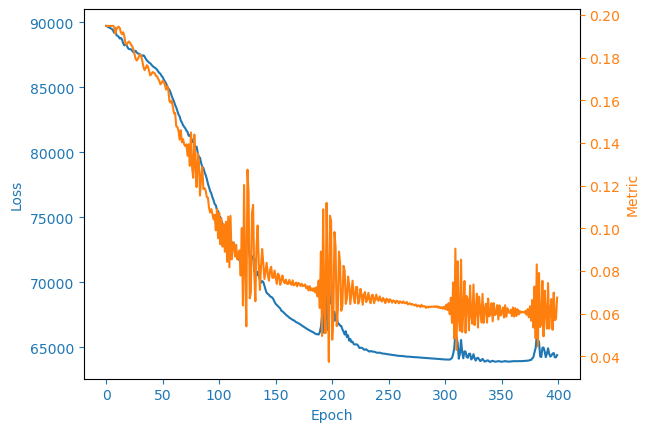

In [20]:
X_train_augmented = np.vstack([Xtrain, Xsobol])
y_train_augmented = np.hstack([ytrain[:,-1], ysobol[:,-1]])
load = False
save_path = f'STORAGE/AI_MODEL_3D_DIM_{dim_devs}_BINARY_SLACK_CLASSIFIER.pth'
binary_slack_classifier = otaf.surrogate.BinaryClassificationModel(
    dim_devs, 2, 
    Xtrain, ytrain[:,-1], 
    slack_threshold=0.0,
    clamping=True, 
    clamping_threshold=1.0,
    max_epochs=400, 
    batch_size=70000, 
    train_size=0.70,
    display_progress_disable=True,
    squeeze_labels = True,
    labels_to_long = True,
    use_dual_target = False)

lr=0.003

binary_slack_classifier.model = otaf.torch.nn.Sequential(
    *otaf.surrogate.get_custom_mlp_layers([dim_devs, dim_devs*3], activation_class = otaf.torch.nn.LeakyReLU,),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs*3, dim_devs*2], activation_class = otaf.torch.nn.SELU,
                                         dropout_class = otaf.torch.nn.AlphaDropout, dropout_kwargs = {'p':0.05}),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs*2, dim_devs, dim_devs//2, 10, 2], activation_class = otaf.torch.nn.Tanhshrink))

binary_slack_classifier.optimizer = otaf.torch.optim.AdamW(binary_slack_classifier.parameters(), lr=lr, weight_decay=0.002)  # Lion(binary_slack_classifier.parameters(), lr=lr, weight_decay=0.0001) #Adam(neural_model.model.parameters(), lr=lr)#
weight =  otaf.torch.tensor([2.0/(train_success_ratio+1e-9), 2.0/(train_failure_ratio+1e-9)]).float()
binary_slack_classifier.criterion = otaf.torch.nn.CrossEntropyLoss(weight=weight, reduction='sum', label_smoothing=0.09) # otaf.torch.nn.BCEWithLogitsLoss(pos_weight=weight) # otaf.torch.nn.MSELoss()
otaf.surrogate.initialize_model_weights(binary_slack_classifier)
#binary_slack_classifier.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(binary_slack_classifier.optimizer, 1.0025) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
binary_slack_classifier.train_model()
binary_slack_classifier.plot_results()

In [21]:
pred_class = binary_slack_classifier.evaluate_model(Xvalid).cpu().detach().numpy()
ground_truth = yvalid[:,-1]#np.array([res.x[-1] for res in ground_truth_full],dtype="float32")
ground_truth_binary = np.where(ground_truth<0,1,0) #ground truth for the failures.

# Optimize thresholds
optimization_results_fn_tn = otaf.surrogate.optimize_thresholds(pred_class, ground_truth_binary, bounds=[-5.0, 5.0], alpha=4.0, optimize_for="minimize_fn_maximize_tn")
optimization_results_tp_fp = otaf.surrogate.optimize_thresholds(pred_class, ground_truth_binary, bounds=[-5.0, 5.0], alpha=20.0, optimize_for="minimize_fp_maximize_tp", equality_decision="success")

print(f"Best Failure Threshold (minimize_fn_maximize_tn): {optimization_results_fn_tn['best_failure_threshold']}")
print(f"Best Success Threshold (minimize_fn_maximize_tn): {optimization_results_fn_tn['best_success_threshold']}")
print("Evaluation Metrics (minimize_fn_maximize_tn):", optimization_results_fn_tn['evaluation'])
print('\n')
print(f"Best Failure Threshold (maximize_tp_minimize_fp): {optimization_results_tp_fp['best_failure_threshold']}")
print(f"Best Success Threshold (maximize_tp_minimize_fp): {optimization_results_tp_fp['best_success_threshold']}")
print("Evaluation Metrics (maximize_tp_minimize_fp):", optimization_results_tp_fp['evaluation'])

Best Failure Threshold (minimize_fn_maximize_tn): 0.000179281451995418
Best Success Threshold (minimize_fn_maximize_tn): 0.13516769187389924
Evaluation Metrics (minimize_fn_maximize_tn): {'confusion_matrix': array([[26610, 15230],
       [  249,  7911]]), 'accuracy': 0.69042, 'precision': 0.34186076660472753, 'recall': 0.9694852941176471, 'f1_score': 0.505479058177055, 'true_negatives': 26610, 'false_positives': 15230, 'false_negatives': 249, 'true_positives': 7911}


Best Failure Threshold (maximize_tp_minimize_fp): 1.1328125
Best Success Threshold (maximize_tp_minimize_fp): -1.2132256191172362e-17
Evaluation Metrics (maximize_tp_minimize_fp): {'confusion_matrix': array([[41510,   330],
       [ 5677,  2483]]), 'accuracy': 0.87986, 'precision': 0.8826875222182723, 'recall': 0.3042892156862745, 'f1_score': 0.45256538776998084, 'true_negatives': 41510, 'false_positives': 330, 'false_negatives': 5677, 'true_positives': 2483}


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ground_truth_binary, otaf.surrogate.generate_corrected_binary_predictions(pred_class, 0.0, 0.0))
cm_corr_fn_tn = confusion_matrix(ground_truth_binary, pred_failures_corr_fn_tn)
cm_corr_tp_fp = confusion_matrix(ground_truth_binary, pred_failures_corr_tp_fp)
otaf.surrogate.plot_confusion_matrix(cm)
otaf.surrogate.plot_confusion_matrix(cm_corr_fn_tn)
otaf.surrogate.plot_confusion_matrix(cm_corr_tp_fp)

## Use the binary classifier to pre-process random samples, and to only calculate the points where we are

## Predict the slack using the gaps and the defects, and introduce noise in the gaps for training.

Works but not so interesting after all...

In [ ]:
load = False
X_train_plays = np.hstack([Xtrain, y_plays]) # Input vector for the training. We use both input defects and gaps combined
combined_dim = X_train_plays.shape[1]
save_path = f'STORAGE/AI_MODEL_3D_DIM_{combined_dim}_SLACK_FROM_GAPS_AND_DEF.pth'
neural_model_gap_def_2_slack = otaf.surrogate.NeuralRegressorNetwork(
    combined_dim, 1,
    X_train_plays, y_slack, 
    clamping=True, 
    max_epochs=200, 
    batch_size=7000, 
    compile_model=True, 
    train_size=0.60, 
    save_path = save_path,
    input_description=list(map(str,TAMP.gap_symbols)),
    display_progress_disable=True,
    output_normalization=False,
    noise_dims=list(range(dim_devs, combined_dim)),
    noise_level=0.05,
    r2_finish=0.95,)

lr=0.0001

neural_model_gap_def_2_slack.model = otaf.surrogate.get_base_relu_mlp_model(combined_dim, 1, False)
#neural_model_gap_def_2_slack.model = KAN([combined_dim, combined_dim//2, combined_dim//4, 1])
neural_model_gap_def_2_slack.optimizer = otaf.torch.optim.AdamW(neural_model_gap_def_2_slack.parameters(), lr=lr, weight_decay=0.004)  # Lion(neural_model_gap_def_2_slack.parameters(), lr=lr, weight_decay=0.0001) ##Adam(neural_model.model.parameters(), lr=lr)#
otaf.surrogate.initialize_model_weights(neural_model_gap_def_2_slack.model)
neural_model_gap_def_2_slack.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model_gap_def_2_slack.optimizer, 1.0025) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
neural_model_gap_def_2_slack.loss_fn = otaf.surrogate.LimitSpaceFocusedLoss(0.0001, 4, square=False) #otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 3, 3, square=True) # 
if os.path.exists(save_path) and load:
    neural_model_gap_def_2_slack.load_model()
else :
    neural_model_gap_def_2_slack.train_model()
    neural_model_gap_def_2_slack.plot_results()
    neural_model_gap_def_2_slack.save_model()

### Now lets train the model from the defects to the gaps

 Works but R2 no better then 0.2...

## Trying to use the information in the matrices from the LP problem to augment the input and predict the gaps.

Only a R2 of 0.56...

In [ ]:
LPNeuralSurrogateTolereancing = otaf.surrogate.LPNeuralSurrogateTolereancing(
    dim_devs, out_dim-1, Xtrain, ytrain[:,:-1], #removing slack
    TAMP.nC, TAMP.nI, TAMP.A_eq_Def, TAMP.A_eq_Gap[:,:-1], TAMP.K_eq, TAMP.A_ub_Def, TAMP.A_ub_Gap[:,:-1], TAMP.K_ub, 
    clamping=True, 
    finish_critertion_epoch=15,
    loss_finish=1e-16, 
    metric_finish=0.95,
    max_epochs=200, 
    batch_size=7000, 
    compile_model=True, 
    train_size=0.70)

lr = 0.0001
LPNeuralSurrogateTolereancing.optimizer = Lion(LPNeuralSurrogateTolereancing.parameters(), lr=lr, weight_decay=0.0001) # otaf.torch.optim.Adam(LPNeuralSurrogateTolereancing.parameters(), lr=lr) # otaf.torch.optim.AdamW(LPNeuralSurrogateTolereancing.parameters(), lr=lr, weight_decay=0.004) #
otaf.surrogate.initialize_model_weights(LPNeuralSurrogateTolereancing)
LPNeuralSurrogateTolereancing.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(LPNeuralSurrogateTolereancing.optimizer, 1.01) #LinearLR(LPNeuralSurrogateTolereancing.optimizer, 1, 0.1, 200)
LPNeuralSurrogateTolereancing.loss_fn = otaf.torch.nn.L1Loss()  # otaf.surrogate.LimitSpaceFocusedLoss(0.001, 2, square=True) # otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True)

LPNeuralSurrogateTolereancing.train_model()
LPNeuralSurrogateTolereancing.plot_results()

## Now we use the defects to predict the gap and the predicted gaps and defects to predict the slack variable

In [ ]:
DualNetworkModel = otaf.surrogate.DualNetworkPredictor(neural_model_defects_2_gaps, neural_model_gap_def_2_slack)
DualNetworkModel.X_def = DualNetworkModel.X_def
DualNetworkModel.y_gap = DualNetworkModel.y_gap
DualNetworkModel.y_slack = DualNetworkModel.y_slack
DualNetworkModel.get_train_test_data(0.3, 42)
#DualNetworkModel.train_model(25000, 
#                            100, 
#                            otaf.torch.nn.MSELoss(),
#                            otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True),
#                            Lion(DualNetworkModel.model_defects_to_gaps.parameters(), lr=0.00001, weight_decay=0.001),                             
#                            Lion(DualNetworkModel.parameters(), lr=0.00001, weight_decay=0.001),)
#DualNetworkModel.plot_results()

ot.RandomGenerator.SetSeed(564868)
rand_vect = np.array(RandDeviationVect.getSample(5))
ground_truth = otaf.uncertainty.compute_gap_optimizations_on_sample(TAMP, rand_vect)

ground_truth = np.array([res.x[-1] for res in ground_truth],dtype="float32")
predicted_slack1 = np.squeeze(predict_slack_via_dual_networks(rand_vect).numpy())
predicted_slack2 = np.squeeze(DualNetworkModel.evaluate_in_batches(rand_vect).numpy())

print(ground_truth)
print(predicted_slack1)
print(predicted_slack2)
print(ground_truth-predicted_slack1)
print(np.abs(ground_truth-predicted_slack1)/np.abs(ground_truth))

In [ ]:
# Predict slack using dual neural networks
#predicted_slack = np.squeeze(predict_slack_via_dual_networks(Xvalid))
predicted_slack = np.squeeze(DualNetworkModel.evaluate_in_batches(Xvalid))# ##
threshold = 0.01
# Calculate R2 and MSE for slack predictions
r2_slack = sklearn.metrics.r2_score(yvalid[..., -1], predicted_slack)
mse_slack = sklearn.metrics.mean_squared_error(yvalid[..., -1], predicted_slack)
print(f"R2 for Slack                        : {r2_slack:.6f}")
print(f"MSE for Slack                       : {mse_slack:.6f}")

# Calculate R2 and MSE for positive slack predictions
yvalid_slack_positive = np.where(yvalid[..., -1] < threshold, 0, yvalid[..., -1])
predicted_slack_positive = np.where(predicted_slack < threshold, 0, predicted_slack)
r2_slack_positive = sklearn.metrics.r2_score(yvalid_slack_positive, predicted_slack_positive)
mse_slack_positive = sklearn.metrics.mean_squared_error(yvalid_slack_positive, predicted_slack_positive)
print(f"R2 for Positive Slack               : {r2_slack_positive:.6f}")
print(f"MSE for Positive Slack              : {mse_slack_positive:.6f}")

# Count the number of failed predictions
failed_predicted = np.where(predicted_slack < threshold, 1, 0)
num_failed_predicted = failed_predicted.sum()
print(f"Number of Failed Predictions        : {num_failed_predicted}")

# Count the number of true failed cases
failed_true = np.where(yvalid[..., -1] < threshold, 1, 0)
num_failed_true = failed_true.sum()
print(f"Number of True Failed Cases         : {num_failed_true}")

# Calculate the ratio of failed predictions to true failed cases
failed_prediction_ratio = num_failed_predicted / num_failed_true
print(f"Ratio of Failed Predictions         : {failed_prediction_ratio:.6f}")

# Calculate the number of common failures
common_failures = (np.dot(failed_predicted, failed_true)).sum()
print(f"Number of Common Failures           : {common_failures}")

# Calculate the ratio of common failures to true failed cases
common_failure_ratio = common_failures / num_failed_true
print(f"Ratio of Common Failures            : {common_failure_ratio:.6f}")


# Calculating probability of failure in the whole imprecise space

### Using the neural network surrogate model and bruteforce montecarlo.

In [22]:
optimizer_milp_ai  = otaf.uncertainty.SocAssemblyAnalysisOptimized(binary_slack_classifier, TAMP, Xvalid, yvalid)
optimizer_milp_ai.optimize_thresholds(bounds=[-5.0, 5.0], alpha_fn=4.0, alpha_fp=30.0)
optimizer_milp_ai

SocAssemblyAnalysisOptimized(
  Binary Classifier: BinaryClassificationModel
  Constraint Matrix Generator: ToleranceAnalysisMatrixPreparer
  X Optimization Shape: (50000, 64)
  Y Optimization Shape: (50000, 68)
  Optimize Results (FN/TN):
    Best Failure Threshold: 0.000179281451995418
    Best Success Threshold: 0.13516769187389924
    Confusion Matrix: 
      TN: 26610
      FP: 15230
      FN: 249
      TP: 7911
  Optimize Results (FP/TP):
    Best Failure Threshold: 1.81610107421875
    Best Success Threshold: 0.0
    Confusion Matrix: 
      TN: 41757,       FP: 83
      FN: 6795,       TP: 1365
)

In [23]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(TAMP.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, TAMP.deviation_symbols)))
N_lambda = 200
lambda_sample_unconditioned = otaf.uncertainty.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, 999)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.uncertainty.condition_lambda_sample(lambda_sample_random, squared_sum=True)

Usually, in reliability, regression models are prefered to classifiers ref{https://www.sciencedirect.com/science/article/pii/S0167473020300989}, but in this case
the performance of the regression wasn't precise enough, and a classifier with some tweaking provided excellent results for reducing the number of calls to the optimization function. 

In [ ]:
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(10*1e6) #1e4
failure_probabilities, s_values = [], []

ot.RandomGenerator.SetSeed(SEED_MC_PF)
sample = np.array(RandDeviationVect.getSample(SIZE_MC_PF))
print('Generated Sample.')

start_time = time()  # Record the start time
for i in range(N_lambda):        
    #composed_dist = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
    #    RandDeviationVect, 
    #    lambda_sample_conditioned[i])
    sample_lambd = sample * np.array(lambda_sample_conditioned[i])
    
    failures = optimizer_milp_ai.soc_optimization_sample(sample_lambd, n_cpu=-2, batch_size=100, progress_bar=False, batch_size_ai=int(1e6))
    failure_probabilities.append(failures.mean())
    print(f"--> Iteration {i}. Failure probability : {failures.mean()}. Min: {min(failure_probabilities)}, / Max: {max(failure_probabilities)}")
    
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

Generated Sample.
Calculating 71 points out of 10000000 so 99.9993% were predicted. With 75 predicted failures.
--> Iteration 0. Failure probability : 7.9e-06. Min: 7.9e-06, / Max: 7.9e-06
Calculating 215 points out of 10000000 so 99.9978% were predicted. With 267 predicted failures.
--> Iteration 1. Failure probability : 3.06e-05. Min: 7.9e-06, / Max: 3.06e-05
Calculating 173 points out of 10000000 so 99.9983% were predicted. With 179 predicted failures.
--> Iteration 2. Failure probability : 1.88e-05. Min: 7.9e-06, / Max: 3.06e-05
Calculating 10 points out of 10000000 so 99.9999% were predicted. With 11 predicted failures.
--> Iteration 3. Failure probability : 1.1e-06. Min: 1.1e-06, / Max: 3.06e-05
Calculating 45 points out of 10000000 so 99.9995% were predicted. With 32 predicted failures.
--> Iteration 4. Failure probability : 3.9e-06. Min: 1.1e-06, / Max: 3.06e-05
Calculating 224 points out of 10000000 so 99.9978% were predicted. With 227 predicted failures.
--> Iteration 5. Fail

In [ ]:
best_worst_quants = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.2)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = best_worst_quants

In [ ]:
print("Lower probability of failure:", "{:.5e}".format(min(failure_probabilities)))
print("Upper probability of failure:", "{:.5e}".format(max(failure_probabilities)))
plt.hist(failure_probabilities)
plt.show()
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda, variable_labels, figsize=(20,5), labels=False)